In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set default figure params
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rc('legend', fontsize='xx-large')
plt.rc('legend', framealpha=0.98)
plt.rc('axes', labelsize='xx-large')

colours = ['b', 'g', 'm', 'c', 'k', 'y']
markers = ['o', '*', 'd', 'X', 'v', '2']

# Illustration of Forward-Backward-Forward (FBF) Algorithm
We want to solve the following problem,
$$ \min_{x\in \mathbb{R}^d}\max_{y\in \mathbb{R}^n}\, f(x) + \Phi(x,y) - h(y) =: \Psi(x,y), $$
for a convex-concave, Frechet differentiable coupling function $\Phi: \mathbb{R}^d \times \mathbb{R}^n \to \mathbb{R}$ with Lipschitz continuous gradient, and convex, proper and lower semicontinuous regularization functions $f:\mathbb{R}^d \to \mathbb{R}\cup\{+\infty\}$ and $h: \mathbb{R}^n \to \mathbb{R}\cup\{+\infty\}$.

For given starting points $x_0 \in \mathbb{R}^d$, $y_0 \in \mathbb{R}^n$ the FBF Algorithm applied to this problem, for $k \in \mathbb{N}$, is given by,

$u_k = \mathrm{prox}_{\alpha f} \left[ x_k - \alpha \nabla_x \Phi(x_k, y_k)\right]$,

$v_k = \mathrm{prox}_{\alpha h} \left[ y_k + \alpha \nabla_y \Phi(x_k, y_k)\right]$,

$x_{k+1} = u_k - \alpha \nabla_x \Phi(u_k, v_k) + \alpha \nabla_x \Phi(x_k, y_k)$,

$y_{k+1} = v_k + \alpha \nabla_y \Phi(u_k, v_k) - \alpha \nabla_y \Phi(x_k, y_k)$.

# Bilinear Objective

We look at an unconstrained Min-Max Problem with bilinear coupling term $\Phi(x,y):= xy$ and (nonsmooth) l1-regularizers $f(x):=\kappa |x|$, $h(y):=\delta_{[-1,1]}(y)$,
$$ \min_{x\in\mathbb{R}} \max_{y\in[-1,1]}\, \Psi(x,y) = xy + \kappa|x| $$


To judge the quality of intermediate solutions we also look at the following gap function
$$ G(x, y) = \sup_{y'\in Y} \Psi(x,y') - \inf_{x'\in X} \Psi(x',y) $$
for $X=Y=[-1,1]$.

In [3]:
def grad(x, y):
    return y, x

def make_prox(rp):
    """return proximal operator for given regularization parameters"""
    def prox(x):
        return np.sign(x)*np.maximum(np.abs(x)-rp,0)
    return prox

def make_gap(rp1):
    """return gap function for given regularization parameters"""
    def gap(x, y):
        abs_x = np.abs(x)
        abs_y = np.abs(y)

        sup = (1+rp1)*abs_x

        inf = np.zeros_like(y)
        for i, abs_y_i in enumerate(abs_y):
            if abs_y_i > rp1:
                inf[i] += rp1 - abs_y_i

        return sup - inf
    return gap

def make_proj(bound):
    def proj(z):
        return np.clip(z, -bound, bound)
    return proj

def update_avg(x_avg, x_new, i):
    """online update of ergodic iterates"""
    return x_avg*(i+1)/(i+2) + x_new/(i+2)

def dist_to_sol(x, y):
    """returns distance to solution of given point"""
    return np.sqrt(x**2 + y**2)


def make_arrow_plot():
    OUTPUT_PATH = 'figure'
    X, Y = np.meshgrid(np.linspace(-3., 3., 10), np.linspace(-3., 3., 10))
    F_x = -Y
    F_y = X
    fig = plt.figure()
    ax = fig.gca()
    ax.quiver(X, Y, F_x, F_y, units='width',color='tab:gray', width=0.002)
    ax.plot(0,0, color = 'red', marker='*')
    ax.plot(x_0, y_0,color = 'red', marker='s')
    ax.set_xlim(-1.5, 2.5)
    ax.set_ylim(-2, 1.5)
    return fig, ax

In [4]:
kappa = 0.01

x_0, y_0 = np.float(2), np.float(0.5)
N_ITER = 500
markevery=0.1
markevery2=0.1
tol = 1e-10

y_prox = make_proj(1)
gap = make_gap(kappa)

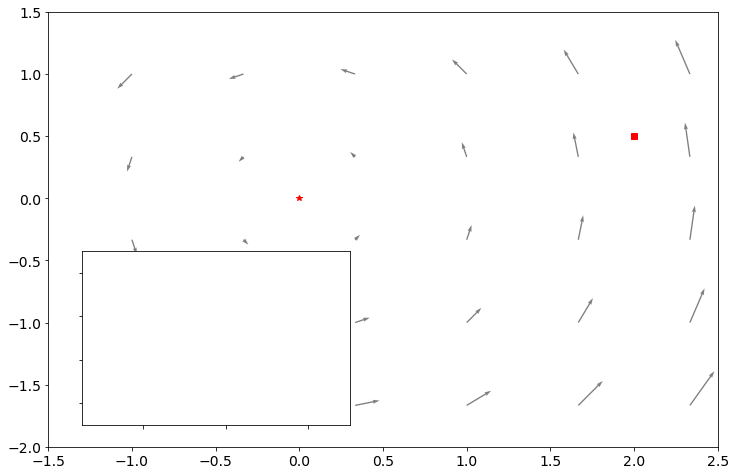

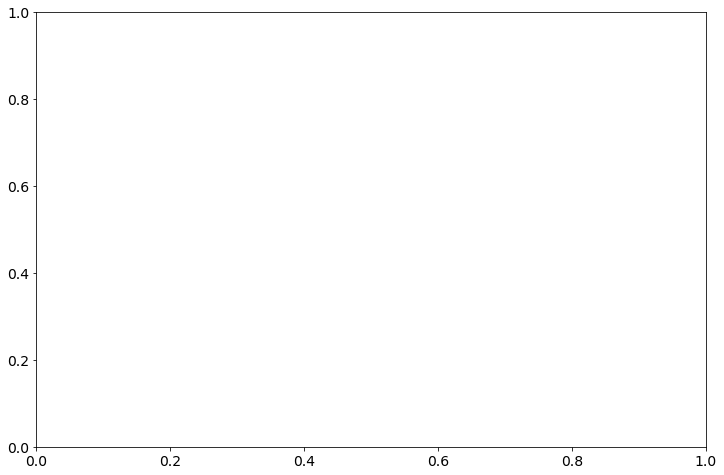

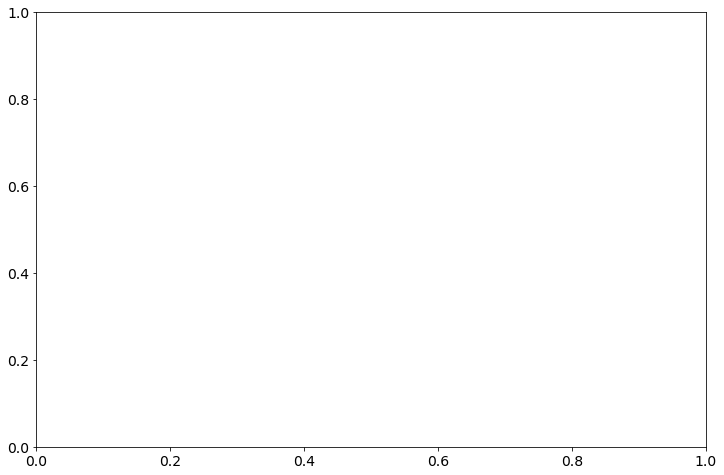

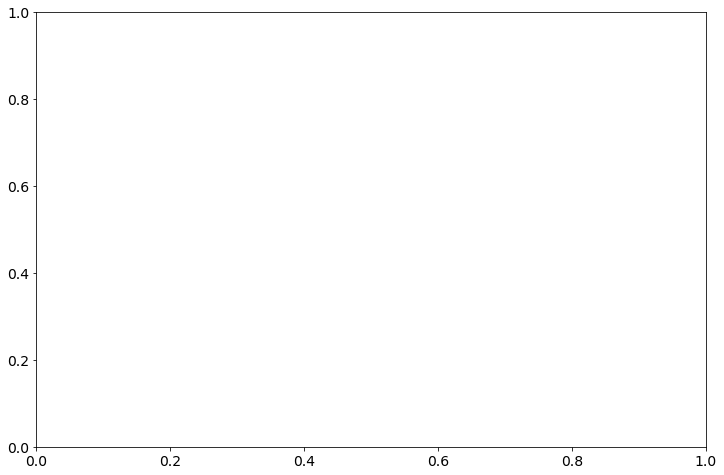

In [5]:
fig1, ax1 = make_arrow_plot()

axins = ax1.inset_axes([0.05, 0.05, 0.4, 0.4])
# sub region of the original image
x1, x2, y1, y2 = -0.15, 0.5, -0.1, 0.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

fig2 = plt.figure(2)
ax2 = fig2.gca()

fig3 = plt.figure(3)
ax3 = fig3.gca()
ax3.axhline(y=0, color = 'tab:gray', linewidth=1)

fig4 = plt.figure(4)
ax4 = fig4.gca()
ax4.axhline(y=0, color = 'tab:gray', linewidth=1)

## Proximal Gradient Descent Ascent

In [6]:
LR = 0.1

x_prox = make_prox(LR*kappa)

x, y = x_0, y_0
x_hist, y_hist = [x], [y]
dist_hist = [dist_to_sol(x, y)]

for i in range(70):
    # step
    g_x, _ = grad(x,y)
    x = x_prox(x - LR*g_x)
    _, g_y = grad(x,y)
    y = y_prox(y + LR*g_y)
    
    # store
    x_hist.append(x), y_hist.append(y)
    dist_hist.append(dist_to_sol(x, y))

print(i+1, dist_hist[-1])

70 0.9788806299829271


### plot iterates

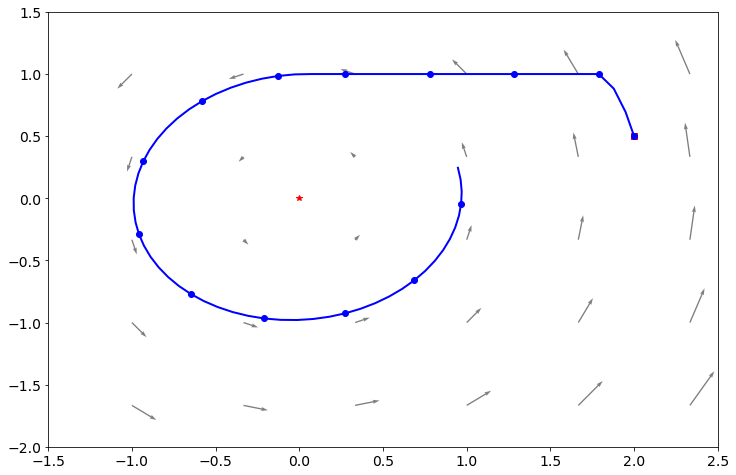

In [7]:
ax1.plot(x_hist, y_hist, c=colours[0], alpha=1,linewidth=2,
         label=f'PGDA $\\alpha={LR}$',markevery=markevery, marker=markers[0])

fig, ax = make_arrow_plot()
ax.plot(x_hist, y_hist, c=colours[0], alpha=1, linewidth=2, markevery=markevery,
        marker=markers[0])

## Extragradient 

In [8]:
LR = 1

x_prox = make_prox(LR*kappa)

x, y = x_0, y_0
x_hist, y_hist = [x], [y]
x_avg, y_avg = x, y
dist_hist = [dist_to_sol(x, y)]

for i in range(N_ITER):
    # extrapolation
    g_x, g_y = grad(x,y)
    x_ = x_prox(x - LR*g_x)
    y_ = y_prox(y + LR*g_y)
    
    # step
    g_x_, g_y_ = grad(x_,y_)
    x = x_prox(x - LR*g_x_)
    y = y_prox(y + LR*g_y_)
    
    # store
    x_avg = update_avg(x_avg, x, i)
    y_avg = update_avg(y_avg, y, i)
    
    x_hist.append(x_avg), y_hist.append(y_avg)
    dist_hist.append(dist_to_sol(x_avg, y_avg))

print(i+1, dist_hist[-1])

500 0.006374769541123707


### plot iterates

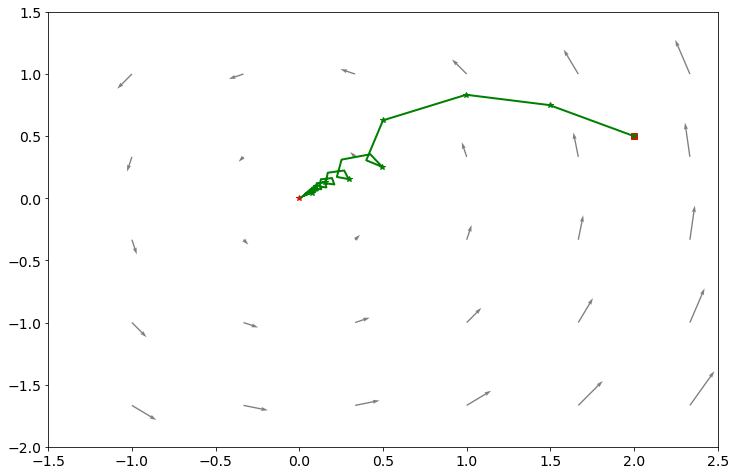

In [9]:
ax1.plot(x_hist, y_hist, c=colours[1],alpha=1,linewidth=2, 
         label=f'EG $\\alpha={LR}$', markevery=markevery, marker=markers[1])
axins.plot(x_hist, y_hist, c=colours[1], alpha=1, linewidth=2, markevery=markevery, marker=markers[1])
ax2.plot(dist_hist, c=colours[1], label=f'EG $\\alpha={LR}$', 
         markevery=markevery2, marker=markers[1])
ax3.plot(gap(x_hist, y_hist), c=colours[1], label=f'EG $\\alpha={LR}$', 
         markevery=markevery2, marker=markers[1])

fig, ax = make_arrow_plot()
ax.plot(x_hist, y_hist, c=colours[1],alpha=1,linewidth=2, markevery=markevery,
        marker=markers[1])

## Extragradient from the past

In [10]:
LR = 0.5

x_prox = make_prox(LR*kappa)

x, y = x_0, y_0
g_x_, g_y_ = grad(x,y)
x_hist, y_hist = [x], [y]
x_avg, y_avg = x, y
dist_hist = [dist_to_sol(x, y)]

for i in range(N_ITER):
    # extrapolate
    x_ = x_prox(x - LR*g_x_)
    y_ = y_prox(y + LR*g_y_)
    
    # step
    g_x_, g_y_ = grad(x_,y_)
    x = x_prox(x - LR*g_x_)
    y = y_prox(y + LR*g_y_)
    
    # store
    x_avg = update_avg(x_avg, x, i)
    y_avg = update_avg(y_avg, y, i)
    
    x_hist.append(x_avg),y_hist.append(y_avg)
    dist_hist.append(dist_to_sol(x_avg, y_avg))

print(i+1, dist_hist[-1])

500 0.009212600955035703


### plot iterates

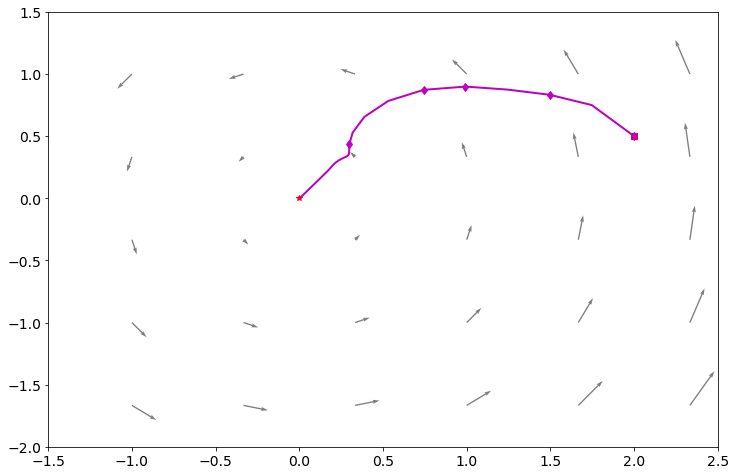

In [11]:
ax1.plot(x_hist, y_hist, c=colours[2], alpha=1, linewidth=2, label=f'EGp $\\alpha={LR}$', 
         markevery=markevery, marker=markers[2])
axins.plot(x_hist, y_hist, c=colours[2], alpha=1, linewidth=2, markevery=markevery, marker=markers[2])
ax2.plot(dist_hist, c=colours[2], label=f'EGp $\\alpha={LR}$', markevery=markevery2, 
         marker=markers[2])
ax3.plot(gap(x_hist, y_hist), c=colours[2], label=f'EGp $\\alpha={LR}$', 
         markevery=markevery2, marker=markers[2])

fig, ax = make_arrow_plot()
ax.plot(x_hist, y_hist, c=colours[2],alpha=1,linewidth=2,markevery=markevery, 
        marker=markers[2])

## Forward-Backward-Forward (FBF)

In [12]:
LR = 1.0

x_prox = make_prox(LR*kappa)

x, y = x_0, y_0
u, v = x, y
u_hist, v_hist = [u], [v]
# start with (u_0,v_0), not (x_0,y_0)
u_avg, v_avg = 0, 0

x_hist, y_hist = [x], [y]
x_avg, y_avg = x, y
dist_hist = [dist_to_sol(u, v)]

for i in range(N_ITER):
    # step
    g_x, g_y = grad(x,y)
    u = x_prox(x - LR*g_x)
    v = y_prox(y + LR*g_y)
    
    # correction
    g_u, g_v = grad(u,v)
    x = u - LR*g_u + LR*g_x
    y = v + LR*g_v - LR*g_y
    
    # store
    u_avg = update_avg(u_avg, u, i-1)
    v_avg = update_avg(v_avg, v, i-1)
    
    x_avg = update_avg(x_avg, x, i)
    y_avg = update_avg(y_avg, y, i)
    x_hist.append(x_avg), y_hist.append(y_avg)
    
    u_hist.append(u_avg), v_hist.append(v_avg)
    dist_hist.append(dist_to_sol(x_avg, y_avg))

print(i+1, dist_hist[-1])

500 0.005976635877618542


### plot iterates

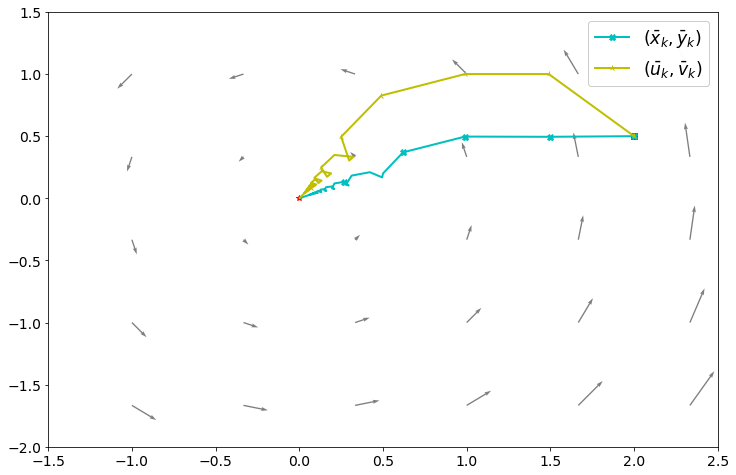

In [13]:
ax1.plot(u_hist, v_hist, c=colours[3], alpha=1, linewidth=2, label=f'FBF $\\alpha={LR}$', 
         markevery=markevery, marker=markers[3])
axins.plot(u_hist, v_hist, c=colours[3], alpha=1, linewidth=2, markevery=markevery, marker=markers[3])
ax2.plot(dist_hist, c=colours[3], label=f'FBF $\\alpha={LR}$', markevery=markevery2, 
         marker=markers[3])
ax3.plot(gap(u_hist, v_hist), c=colours[3], label=f'FBF $\\alpha={LR}$', 
         markevery=markevery2, marker=markers[3])

fig, ax = make_arrow_plot()
ax.plot(x_hist, y_hist, c=colours[3], alpha=1, linewidth=2, markevery=markevery, 
        marker=markers[3], label='$(\\bar{x}_k,\\bar{y}_k)$')
ax.plot(u_hist, v_hist, c=colours[5], alpha=1, linewidth=2, markevery=markevery, 
        marker=markers[5], label='$(\\bar{u}_k,\\bar{v}_k)$')
ax.legend()

## FBFp

corresponds to OGDA+regularizers

In [14]:
LR = 0.5

x_prox = make_prox(LR*kappa)

x, y = x_0, y_0
g_u, g_v = grad(x,y)
u, v = x, y
u_hist, v_hist = [u], [v]
u_avg, v_avg = u, v
dist_hist = [dist_to_sol(u, v)]

for i in range(N_ITER):
    # step
    g_u_, g_v_ = g_u, g_v
    g_u, g_v = grad(u, v)
    u = x_prox(u - 2*LR*g_u + LR*g_u_)
    v = y_prox(v + 2*LR*g_v - LR*g_v_)
    
    # store
    u_avg = update_avg(u_avg, u, i)
    v_avg = update_avg(v_avg, v, i)
    
    u_hist.append(u_avg), v_hist.append(v_avg)
    dist_hist.append(dist_to_sol(u_avg, v_avg))

print(i+1, dist_hist[-1])

500 0.00764166425629743


### plot iterates

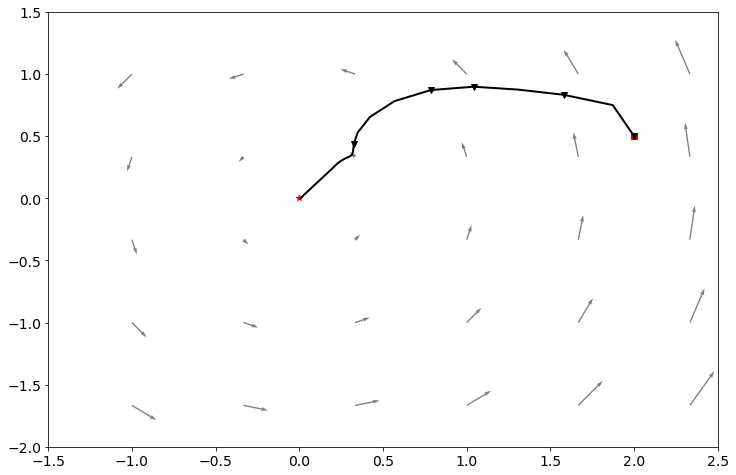

In [15]:
ax1.plot(u_hist, v_hist, c=colours[4], alpha=1, linewidth=2, label=f'FBFp $\\alpha={LR}$',
         markevery=markevery, marker=markers[4])
axins.plot(u_hist, v_hist, c=colours[4], alpha=1, linewidth=2, markevery=markevery, marker=markers[4])
ax2.plot(dist_hist, c=colours[4], label=f'FBFp $\\alpha={LR}$', markevery=markevery2,
         marker=markers[4])
ax3.plot(gap(u_hist, v_hist), c=colours[4], label=f'FBFp $\\alpha={LR}$', 
         markevery=markevery2, marker=markers[4])

fig, ax = make_arrow_plot()
ax.plot(u_hist, v_hist, c=colours[4], alpha=1, linewidth=2, markevery=markevery,
        marker=markers[4])

## Summary

### All trajectories

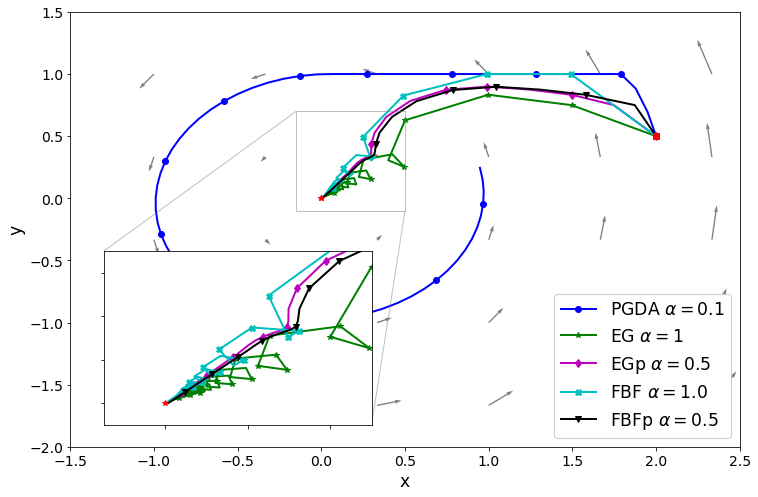

In [16]:
ax1.plot(0, 0, color='red', marker='*')
axins.plot(0, 0, color='red', marker='*')
ax1.plot(x_0,y_0,color = 'red',marker='s')
ax1.legend(loc=4)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.indicate_inset_zoom(axins)

fig1

optionally save figure for use in the paper

In [17]:
fig1.savefig('all_traj.pdf')

### Distance to solution

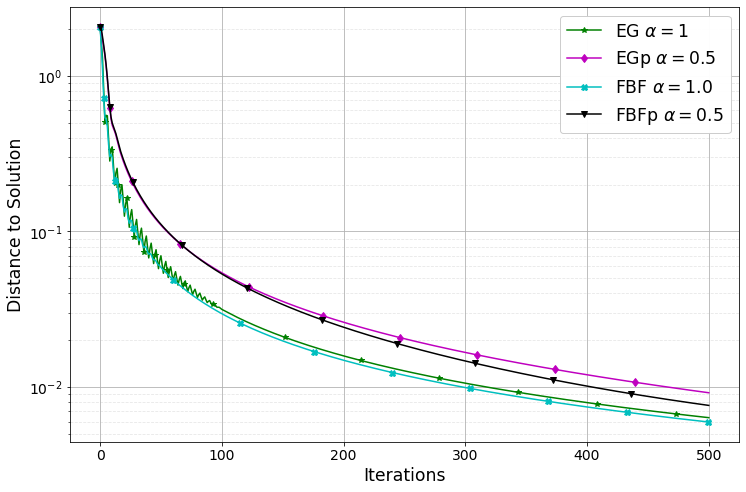

In [18]:
ax2.set_yscale('log')
ax2.legend()
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Distance to Solution')
ax2.grid(b=True, which='major', linestyle='-')
ax2.grid(b=True, which='minor', linestyle='--', alpha=0.3)
fig2

### Gap function

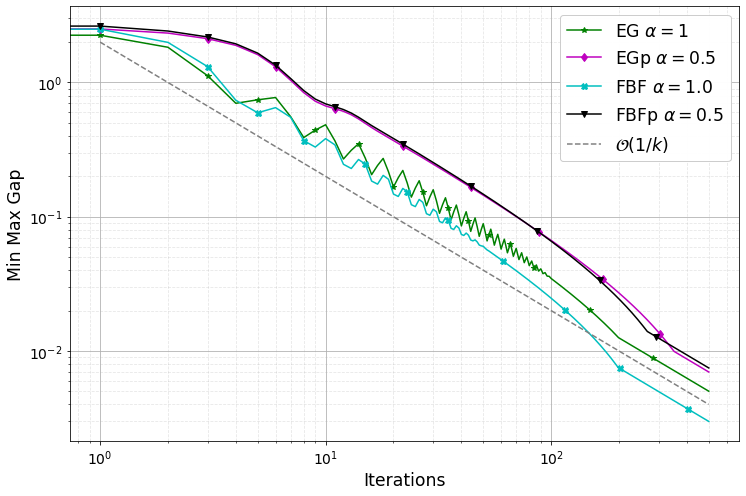

In [19]:
ax3.set_yscale('log')
ax3.set_xscale('log')
x = np.arange(1, N_ITER)
ax3.plot(x, 1/x*2, c='grey', label='$\mathcal{O}(1/k)$', linestyle='--')
ax3.legend()
ax3.grid(b=True, which='major', linestyle='-')
ax3.grid(b=True, which='minor', linestyle='--', alpha=0.3)
ax3.set_xlabel('Iterations')
ax3.set_ylabel('Min Max Gap')
fig3

optionally save figure

In [20]:
fig3.savefig('gap_function.pdf')